In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import einops
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
n_epochs = 30

trainset = torchvision.datasets.CIFAR10(root='./data/cifar-10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data/cifar-10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: B, 3, 32, 32
        # 3 conv layers
        self.conv_layers = nn.Sequential(nn.Conv2d(3, 8, 3, padding="same"),
                                         nn.LeakyReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding="same"),
                                         nn.LeakyReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding="same"),
                                         nn.LeakyReLU(),
                                         nn.MaxPool2d(2))
        # Output: B, 32, 4, 4
        # 3 feed forward layers
        self.fcn_layers = nn.Sequential(nn.Linear(32 * 4 * 4, 256),
                                        nn.LeakyReLU(),
                                        nn.Linear(256, 64),
                                        nn.LeakyReLU(),
                                        nn.Linear(64, 10))
        # Output: B, 10
    
    def forward(self, x):
        # Input: B, 3, 128, 128
        # B, 32, 16, 16
        x = self.conv_layers(x)
        b = x.shape[0]
        # B, 32 * 16 * 16
        x = x.reshape(b, -1)
        # B, 10
        x = self.fcn_layers(x)
        return x

class ViT(nn.Module):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.embed_layers = nn.Sequential(nn.Linear(3 * 8 * 8, embed_dim))
        
        self.pos_emb = nn.Parameter(torch.zeros((1 + 16 + 9, embed_dim)))
        nn.init.xavier_uniform_(self.pos_emb)

        self.q_layers = [nn.Linear(embed_dim, embed_dim) for _ in range(3)]
        self.k_layers = [nn.Linear(embed_dim, embed_dim) for _ in range(3)]
        self.v_layers = [nn.Linear(embed_dim, embed_dim) for _ in range(3)]
        self.attn_layers = [nn.MultiheadAttention(embed_dim, 8, batch_first=True) for _ in range(3)]
        self.attn_norm_layers = [nn.LayerNorm(embed_dim) for _ in range(3)]
        self.fcn_layers = [nn.Sequential(nn.Linear(embed_dim, embed_dim), nn.GELU()) for _ in range(3)]
        self.fcn_norm_layers = [nn.LayerNorm(embed_dim) for _ in range(3)]

        self.cls_token = nn.Parameter(torch.zeros((1, 1, 3 * 64)))
        nn.init.xavier_uniform_(self.cls_token)                           
        self.out_layers = nn.Linear(embed_dim, 10)

    def forward(self, x):
        # Input: B, 3, 32, 32
        # Extract patches
        # B, 64, 3 * 4 * 4
        patches1 = einops.rearrange(x, "b c (m h) (n w) -> b (m n) (c h w)", h = 8, w = 8)
        patches2 = einops.rearrange(x[:, :, 4:-4, 4:-4], "b c (m h) (n w) -> b (m n) (c h w)", h = 8, w = 8)
        # B, 4 * 4 + 3 * 3, 3 * 8 * 8
        n_batch = x.shape[0]
        cls_token = einops.repeat(self.cls_token, "1 1 d -> b 1 d", b = n_batch)
        patches = torch.concatenate((cls_token, patches1, patches2), dim = 1)
        # B, 64, 64
        embeddings = self.embed_layers(patches)
        # B, 64, 64
        embeddings += self.pos_emb

        for q, k, v, attn, attn_norm, fcn, fcn_norm in zip(self.q_layers, self.k_layers, self.v_layers, self.attn_layers, self.attn_norm_layers, self.fcn_layers, self.fcn_norm_layers):
            attn_out, _ = attn(q(embeddings), k(embeddings), v(embeddings), need_weights=False)
            # attn_out, _ = attn(embeddings, embeddings, embeddings, need_weights=False)
            embeddings = attn_norm(embeddings + attn_out)

            fcn_out = fcn(embeddings)
            embeddings = fcn_norm(embeddings + fcn_out)

        out = self.out_layers(embeddings[:, 0, :])
        return out


cnn = CNN()
vit = ViT(embed_dim=32)
loss_fn = nn.CrossEntropyLoss()

Epoch: 0, Loss: 2.0067310333251953
Epoch: 1, Loss: 1.9073688983917236
Epoch: 2, Loss: 1.8529987335205078
Epoch: 3, Loss: 1.8145644664764404
Epoch: 4, Loss: 1.7494838237762451
Epoch: 5, Loss: 1.710129737854004
Epoch: 6, Loss: 1.6869001388549805
Epoch: 7, Loss: 1.6679918766021729
Epoch: 8, Loss: 1.6478807926177979
Epoch: 9, Loss: 1.6338273286819458
Epoch: 10, Loss: 1.617845892906189
Epoch: 11, Loss: 1.6052215099334717
Epoch: 12, Loss: 1.5919417142868042
Epoch: 13, Loss: 1.5810699462890625
Epoch: 14, Loss: 1.568928837776184
Epoch: 15, Loss: 1.559486746788025
Epoch: 16, Loss: 1.5505708456039429
Epoch: 17, Loss: 1.5424848794937134
Epoch: 18, Loss: 1.5338728427886963
Epoch: 19, Loss: 1.5282059907913208


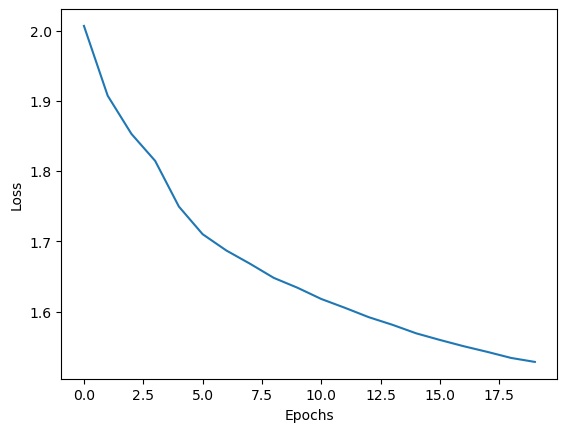

In [3]:
def train(model, n_epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    loss_per_epoch = []
    for epoch in range(n_epochs):
        loss_epoch = []
        for x, y_targ in trainloader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y_targ)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())
        loss_epoch = torch.mean(torch.tensor(loss_epoch)).item()
        print(f"Epoch: {epoch}, Loss: {loss_epoch}")
        loss_per_epoch.append(loss_epoch)
    plt.figure()
    plt.plot(loss_per_epoch)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
train(vit, 20, 1e-3)

Accuracy: 0.438600
TRUE
['horse', 'dog', 'ship', 'plane']
['ship', 'bird', 'horse', 'plane']
['cat', 'dog', 'cat', 'ship']
['cat', 'dog', 'car', 'horse']
PREDICTION
['deer', 'dog', 'ship', 'ship']
['ship', 'deer', 'dog', 'ship']
['dog', 'horse', 'cat', 'dog']
['cat', 'dog', 'car', 'horse']


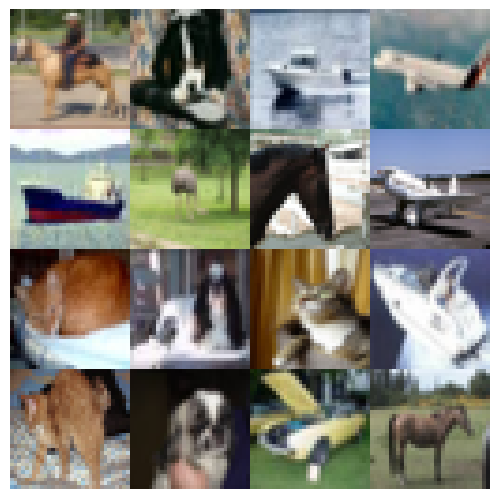

In [10]:
def eval(model):
    numerator, denominator = 0, 0
    for i, (x, y_targ) in enumerate(testloader):
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim = 1)
            numerator += torch.sum(y_pred == y_targ)
            denominator += x.shape[0]
    print(f"Accuracy: {numerator/denominator:2f}")
    x.shape
    m, n = 4, 4
    x_viz = einops.rearrange(x, "(m n) c h w -> (m h) (n w) c", m = 4, n = 4)
    x_viz = (x_viz + 1) / 2

    plt.figure()
    plt.imshow(x_viz)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig("figures/cifar_samples.png", dpi=600)
    
    classes_true = [classes[i] for i in y_targ]
    classes_pred = [classes[i] for i in y_pred]
    
    def viz_classes(classes, m, n):
        for i in range(m):
            print(classes[n * i: n * (i+1)])
    
    print("TRUE")
    viz_classes(classes_true, 4, 4)
    
    print("PREDICTION")
    viz_classes(classes_pred, 4, 4)
eval(vit)

Epoch: 0, Loss: 1.5130655765533447
Epoch: 1, Loss: 1.1300256252288818
Epoch: 2, Loss: 0.9841029047966003
Epoch: 3, Loss: 0.8846738338470459
Epoch: 4, Loss: 0.8093753457069397
Epoch: 5, Loss: 0.7409425973892212
Epoch: 6, Loss: 0.672443687915802
Epoch: 7, Loss: 0.6208926439285278
Epoch: 8, Loss: 0.5673884153366089
Epoch: 9, Loss: 0.5231689214706421
Epoch: 10, Loss: 0.47664564847946167
Epoch: 11, Loss: 0.4421389102935791
Epoch: 12, Loss: 0.4018852114677429
Epoch: 13, Loss: 0.36889177560806274
Epoch: 14, Loss: 0.35795849561691284
Epoch: 15, Loss: 0.3248421847820282
Epoch: 16, Loss: 0.2972325086593628
Epoch: 17, Loss: 0.2909054458141327
Epoch: 18, Loss: 0.2745669186115265
Epoch: 19, Loss: 0.26170364022254944
Accuracy: 0.671100
TRUE
['horse', 'dog', 'ship', 'plane']
['ship', 'bird', 'horse', 'plane']
['cat', 'dog', 'cat', 'ship']
['cat', 'dog', 'car', 'horse']
PREDICTION
['horse', 'cat', 'ship', 'plane']
['ship', 'deer', 'dog', 'plane']
['cat', 'deer', 'deer', 'ship']
['cat', 'dog', 'deer', 

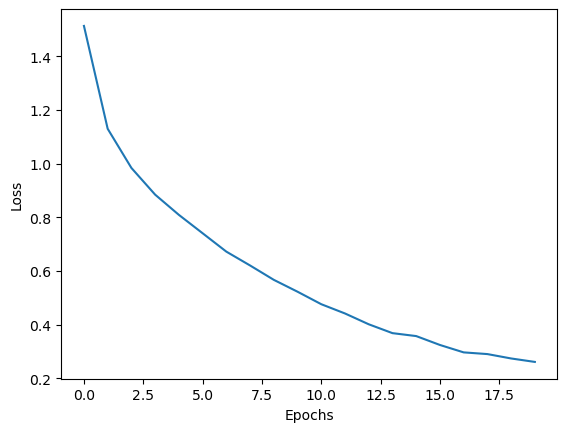

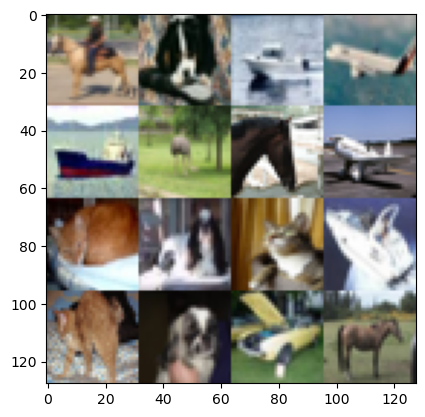

In [5]:
train(cnn, 20, 3e-3)
eval(cnn)

In [6]:
def count_params(model):
    params = 0
    for param in model.parameters():
        params += param.numel()
    return params
print(count_params(vit))
print(count_params(cnn))

7530
154458
